<a href="https://colab.research.google.com/github/Alex-AI-code/PRA3024/blob/main/Assignment_1_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
!{sys.executable} -m pip install lalsuite pycbc

!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf
!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf


File ‘H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf’ already there; not retrieving.

File ‘L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf’ already there; not retrieving.



# Imports

In [2]:
from __future__ import division

import numpy as np
import lal
import lalsimulation

import matplotlib.pyplot as plt
from scipy import interpolate
from numpy import pi
from scipy import constants
from pycbc.conversions import *
from astropy import cosmology
from pycbc import waveform
import pylab


from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.frame import read_frame

import pycbc.psd
from pycbc.psd import interpolate

# Exercise 1

## Downsample the data at a samling rate of 2048Hz

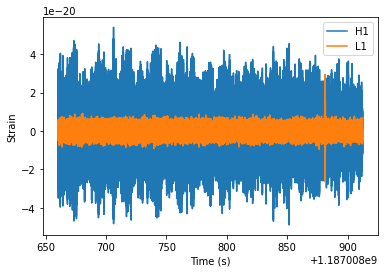

In [3]:
merger = Merger("GW170817")
strain, stilde = {}, {}
for ifo in ['H1', 'L1']:

    ts = read_frame("{}-{}_LOSC_CLN_4_V1-1187007040-2048.gwf".format(ifo[0], ifo),
                    '{}:LOSC-STRAIN'.format(ifo),
                   start_time=merger.time - 224,
                   end_time=merger.time + 32,
                   check_integrity=False)



    #Apply highpass to remove low frequencies and downsample
    strain[ifo] = resample_to_delta_t(highpass(ts, 15.0), 1.0/2048)

    # crop the data to get rid of the edge problems
    strain[ifo] = strain[ifo].crop(2, 2)

    # Convert to frequency serie
    stilde[ifo] = strain[ifo].to_frequencyseries()

    #plotting both datasets
    pylab.plot(strain[ifo].sample_times, strain[ifo], label=ifo)


pylab.ylabel('Strain')
pylab.xlabel('Time (s)')
pylab.legend()
pylab.show()

#This brings the dynamic range of the data largely into the same range

## Matched filter between the given data and a template waveform 



### PSD of the data
This graph will show use the variation of the noise power over the frequency.

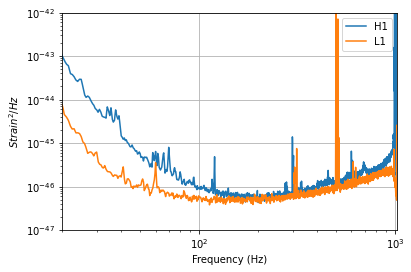

In [4]:
#it is important to whiten the data in order to find the SNR

psds = {}
for ifo in ['H1', 'L1']:


    delta_t = strain[ifo].delta_t
    seg_len = int(2 / delta_t)
    seg_stride = int(seg_len / 2)

    # I use a version of welch method to estimate the PSD
    psds[ifo]  = pycbc.psd.welch(strain[ifo],
                      seg_len=seg_len,
                      seg_stride=seg_stride)
    
    psds[ifo] = interpolate(psds[ifo], stilde[ifo].delta_f)

    pylab.loglog(psds[ifo].sample_frequencies, psds[ifo], label=ifo)
    pylab.xlim(20, 1024)
    pylab.ylim(1e-47, 1e-42)

pylab.ylabel('$Strain^2 / Hz$')
pylab.xlabel('Frequency (Hz)')
pylab.grid()
pylab.legend()

# There is a lot of noise at low frequencies, big spikes are present which indicate large power at specific frequencies 

## Find the best solar mass
SNR plot versus total mass of the system

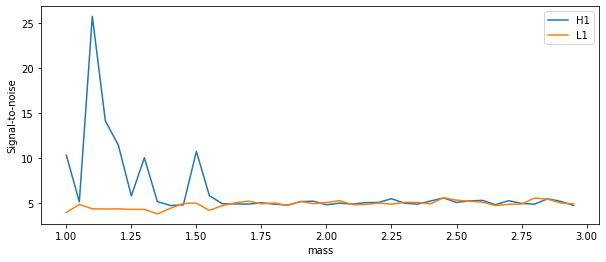

In [5]:
from pycbc.waveform import get_td_waveform
from pycbc.filter import matched_filter
from numpy import arange


Snr_list = []
snrs = {}

# range of the masses 
start = 1
stop = 3
interval = 0.05

masses = arange(start,stop,interval)

for ifo in ['H1', 'L1']:
  for m in (arange(start,stop,interval)):
    m = round(m,2)
    hp, hc = get_td_waveform(approximant="TaylorT2",
                            mass1=m,
                            mass2=m,
                            delta_t=strain[ifo].delta_t,
                            f_lower=15.0)

    hp.resize(len(strain[ifo]))
    template = hp.cyclic_time_shift(hp.start_time)

    snr = matched_filter(template, strain[ifo],
                        psd=psds[ifo], 
                        low_frequency_cutoff=15.0)
    snr1 = snr.crop(4 + 4, 4)
    snrs[ifo] = Snr_list.append(max(abs(snr1)))
  snrs[ifo] = Snr_list
  Snr_list = []

pylab.figure(figsize=[10, 4])
pylab.plot(masses, snrs['H1'], label= 'H1')
pylab.plot(masses, snrs['L1'], label= 'L1')
pylab.legend()
pylab.ylabel('Signal-to-noise')
pylab.xlabel('mass')
pylab.show()

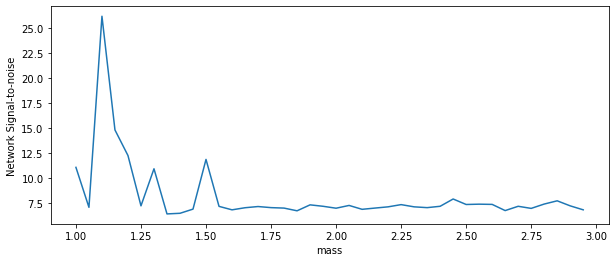

We found the best Mass1=Mass2 was 1.10 solar masses (detector frame)


In [6]:
nsnr = (np.array(snrs['H1'])**2 + np.array(snrs['L1'])**2)**0.5
ii = np.where(nsnr == max(nsnr))
pylab.figure(figsize=[10, 4])
pylab.plot(masses, nsnr)

pylab.ylabel('Network Signal-to-noise')
pylab.xlabel('mass')
pylab.show()

print("We found the best Mass1=Mass2 was %2.2f solar masses (detector frame)" % masses[ii])

## Create template to match the data

### signal model
This part of the matched filter includes laying the potential signal over the data and integrating.
If the data aligns with the template, the value integrated over will become large.

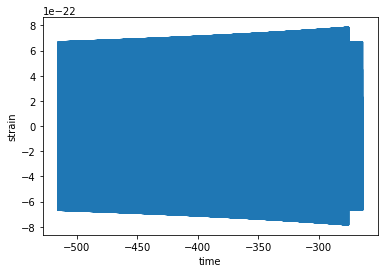

In [7]:
m = 1.10 # Solar masses
conditioned = strain['H1']
hp, hc = get_td_waveform(approximant="TaylorT2",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=15.0)

# Resize the vector
hp.resize(len(conditioned))


# This function rotates the vector by a fixed amount of time.
template = hp .cyclic_time_shift(hp.start_time)



pylab.plot(hp.sample_times, template)
pylab.xlabel('time')
pylab.ylabel('strain')
pylab.show()

### SNR time series
We will calculate the SNR for our template

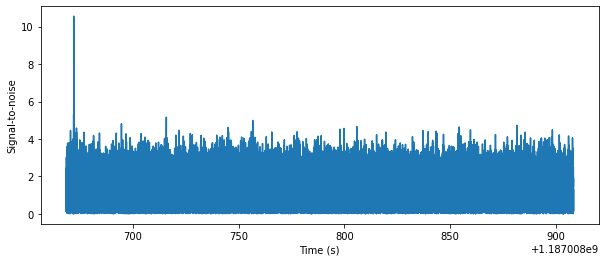

We found a signal at 1187008671.967383s with SNR 10.555424492228699


In [8]:
from pycbc.filter import matched_filter

ifo = 'L1'                            
conditioned = strain[ifo]
snr = matched_filter(template, conditioned,
                     psd=psds[ifo] , low_frequency_cutoff=20)


# We remove 4 seconds at both ends of our snr
# and then 4 more at the start to account for the lenght of the template
snr = snr.crop(4 + 4, 4)


pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()


#abs here is used because the function that we use returns a complex snr

# peak = abs(snr).numpy().argmax()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))


## Q-Tranformation

### Aligning the template
The time, amplitude and phase found previous tell us exactly how to align our template with the data.

In [9]:
from pycbc.filter import sigma

psd=psds[ifo]

# modify the time for the template
dt = time - conditioned.start_time
aligned = template.cyclic_time_shift(dt)

# scale the template
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0)

# modify the amplitude and the phase to match the peak value
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = conditioned.start_time

### Visualize the overlap between template and data
Here we whiten the template and the data in such a way that any signal that is in the data is transformed in the same way that the template is.


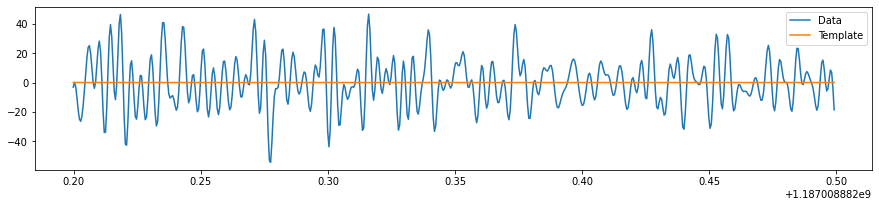

In [10]:
# We do it this way so that we can whiten both the template and the data
white_data = (conditioned.to_frequencyseries() / psd**0.5).to_timeseries()

# apply a smoothing of the turnon of the template to avoid a transient
# from the sharp turn on in the waveform.
tapered = aligned.highpass_fir(30, 512, remove_corrupted=False)
white_template = (tapered.to_frequencyseries() / psd**0.5).to_timeseries()

white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

# Select the time around the merger
white_data = white_data.time_slice(merger.time-.2, merger.time+.1)
white_template = white_template.time_slice(merger.time-.2, merger.time+.1)

pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Data")
pylab.plot(white_template.sample_times, white_template, label="Template")
pylab.legend()
pylab.show()

### Substracting the template from the data
Now that the template should be aligned with the data we can just substract it.

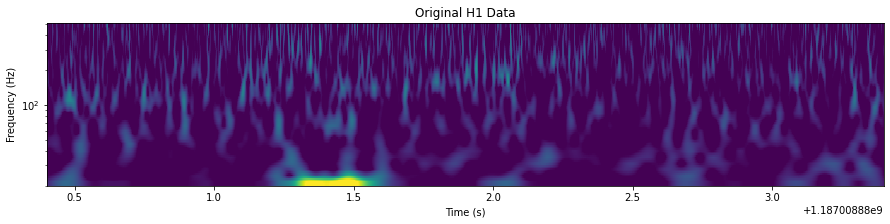

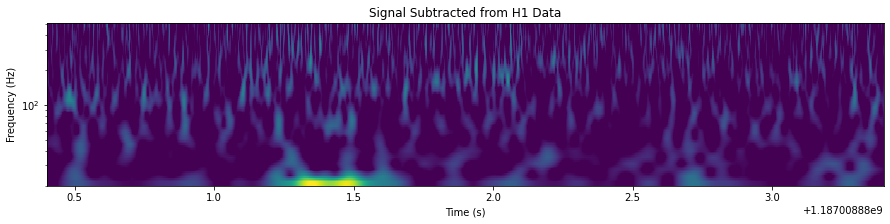

In [11]:
subtracted = conditioned - aligned

# Plot the original data and the subtracted signal data

for data, title in [(conditioned, 'Original H1 Data'),
                    (subtracted, 'Signal Subtracted from H1 Data')]:

    t, f, p = data.whiten(4, 4).qtransform(.001,
                                                  logfsteps=100,
                                                  qrange=(8, 8),
                                                  frange=(20, 512))
    pylab.figure(figsize=[15, 3])
    pylab.title(title)
    pylab.pcolormesh(t, f, p**0.5, vmin=1, vmax=6)
    pylab.yscale('log')
    pylab.xlabel('Time (s)')
    pylab.ylabel('Frequency (Hz)')
    pylab.xlim(merger.time - 2, merger.time + 1)
    pylab.show()

## Here we calculate the match between a wave form and the nearby templates that are generated assuming a certain mass interval

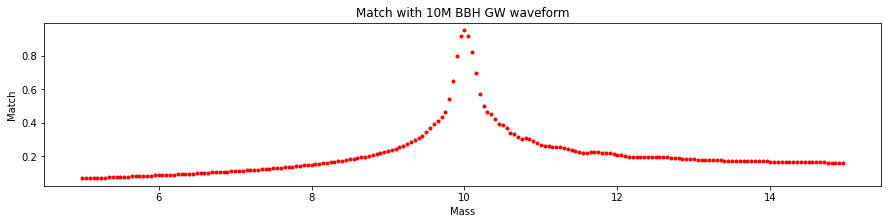

In [12]:
from pycbc.waveform import get_td_waveform
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower


f_low = 30
sample_rate = 4096
masses = arange(5,15,0.05)
# initialize dict
matches = {}

for mass in masses:
  # Generate the two waveforms to compare
  hp, hc = get_td_waveform(approximant="EOBNRv2",
                          mass1=10,
                          mass2=10,
                          f_lower=f_low,
                          delta_t=1.0/sample_rate)

  sp, sc = get_td_waveform(approximant="TaylorT4",
                          mass1=mass,
                          mass2=mass,
                          f_lower=f_low,
                          delta_t=1.0/sample_rate)

  # Resize the waveforms to the same length
  tlen = max(len(sp), len(hp))
  sp.resize(tlen)
  hp.resize(tlen)

  # Generate the aLIGO ZDHP PSD
  delta_f = 1.0 / sp.duration
  flen = tlen//2 + 1
  psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)

  # Note: This takes a while the first time as an FFT plan is generated
  # subsequent calls are much faster.
  m, i = match(hp, sp, psd=psd, low_frequency_cutoff=f_low)

  # append to dict
  matches[mass]=m

pylab.figure(figsize=[15, 3])
pylab.title("Match with 10M BBH GW waveform")
pylab.ylabel('Match')
pylab.xlabel('Mass')
pylab.plot(*zip(*matches.items()),'r.')
pylab.show()

# Exercise 2

## Load the data and take a look at it

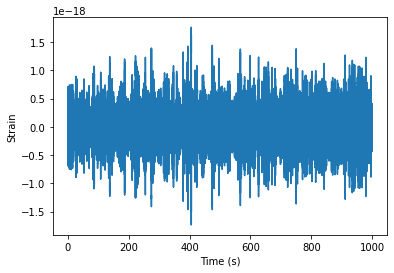

In [13]:
d = np.load('noise_ts_4096Hz.npy')
dt = d[:, 0]
import pycbc.types 
d = pycbc.types.TimeSeries(d[:, 1], delta_t = dt[1]- dt[0])
data = d

#take a look at the data
pylab.plot(data.sample_times, data)
pylab.ylabel('Strain')
pylab.xlabel('Time (s)')
pylab.show()

## plotting the PSD

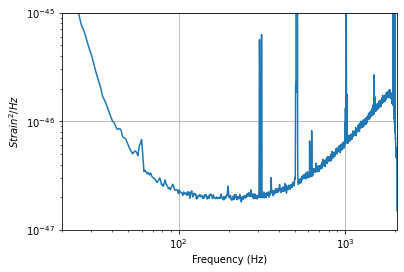

In [14]:
#plot (PSD)
from pycbc.psd import interpolate, welch

psds = interpolate(welch(d), 1.0/d.duration)

pylab.loglog(psds.sample_frequencies, psds)
pylab.xlim(20, max(psds.sample_frequencies))
pylab.ylim(1e-47, 1e-45)
pylab.ylabel('$Strain^2 / Hz$')
pylab.xlabel('Frequency (Hz)')
pylab.grid()
pylab.show()

## Check for any gravitational wave with a range of masses (5-10) with a threshold of 8 as minimum SNR

We did not detect a gravitational wave, this is the max SNR: 6.545257353642936


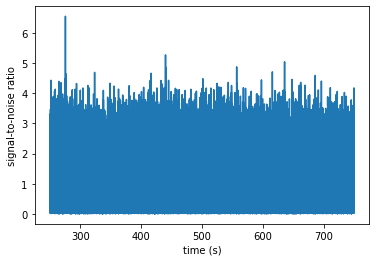

In [15]:
import pycbc.noise
import pycbc.psd
import pycbc.filter
import pycbc.waveform
import pylab


flow = 30 #Hz
stilde = data.to_frequencyseries()


maxsnr = 0
masses = np.arange(5,10,0.05)
snrp = 0

for i in masses:
  hp, hc = pycbc.waveform.get_fd_waveform(approximant="TaylorF2",
                               mass1=i, mass2=i,
                               f_lower=flow, delta_f=stilde.delta_f)

  hp.resize(len(stilde))  
  snr = pycbc.filter.matched_filter(hp, stilde, psd=psds,
                                       low_frequency_cutoff=flow)

# Remove regions corrupted by filter wraparound
  snr = snr[len(snr) // 4: len(snr) * 3 // 4]

# get the biggest snr
  if max(abs(snr)) > maxsnr:
    maxsnr = max(abs(snr))
    snrp = snr

#check if gravitational wave present
if maxsnr < 8:
  print ("We did not detect a gravitational wave, this is the max SNR: {}".format(maxsnr))
else:
  print("We did detect a gravitational wave with SNR: {}".format(maxsnr))


pylab.plot(snrp.sample_times, abs(snrp))
pylab.ylabel('signal-to-noise ratio')
pylab.xlabel('time (s)')
pylab.show()

Whiten the data and construct a histogram of it

In [16]:
# We do it this way so that we can whiten both the template and the data
import pycbc.psd

white_data = (data.to_frequencyseries() / psds**0.5).to_timeseries()

white_data = white_data.crop(4,4)

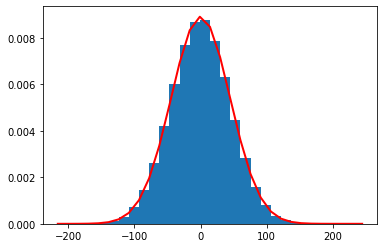

In [17]:
import math
import matplotlib.pyplot as plt
from statistics import mean, stdev

mu, sigma, shape = mean(white_data), stdev(white_data), white_data.shape[0] # mean, standard deviation, shape
s = np.random.normal(mu, sigma, shape)

count, bins, ignored = plt.hist(s, 30, density=True)
plt.plot(bins,
         1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), 
         linewidth=2, color='r')
plt.show()

## Test to see if the stationary assumption holds

In [18]:
# 'hp' wave form in frequency domain
from pycbc.waveform import get_fd_waveform

hp, hc = get_fd_waveform(approximant="TaylorF2",
                         mass1=3,
                         mass2=3,
                         delta_f=1.0/(200.0),
                         distance = 500,
                         f_lower=20.0,
                         f_final = 2048.0)

### Divide the data and estimate the psd for each chunk

In [19]:
from pycbc.filter import sigmasq


max = 1000

slice_data= len(data)/max
slice_data= int(slice_data)
print(slice_data)

SNRlist = []
for i in range(0,max):
  data_chunk = data[i*slice_data:(i+1)*slice_data]
  psd = interpolate(welch(data_chunk),1.0/ d.duration)

  psds = pycbc.psd.interpolate(pycbc.psd.welch(data_chunk),hp.delta_f)

  optSNR = (pycbc.filter.sigmasq(hp, psds))**0.5
  
  SNRlist.append(optSNR)

print(SNRlist)

4096
[13.738390528653273, 14.121807670469206, 14.760599729056793, 15.915632593027588, 15.245841114398035, 17.50619199075558, 16.803048439280154, 15.268385508799438, 14.697961185214556, 14.514769159819737, 17.104748901614776, 15.412329535245174, 14.647888463583078, 14.594401753324707, 19.77918802023768, 16.800279966556634, 15.36138451447297, 16.625322816459573, 13.652666592387588, 14.958110083704982, 16.58380638513512, 16.703054478914893, 17.928662526661192, 15.113642901646514, 15.180085492741668, 16.83556274560357, 13.708708662196472, 18.15607300498775, 15.545846513432886, 16.310250885188566, 14.167426589526945, 17.85349393790731, 15.357292426066968, 18.342347613650478, 16.616064906695442, 14.33245750032731, 16.134434026246925, 14.268534021054961, 15.153058754545661, 16.03421447308775, 16.14951653056265, 15.650254759641491, 14.866589217876015, 14.781072138314125, 16.56077139920997, 15.469555815664126, 14.755973403577013, 17.31964164300603, 17.555099789337486, 17.207369212860392, 15.803

### Plot histogram

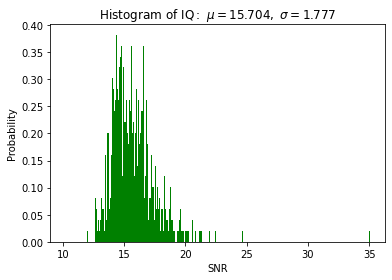

In [20]:
import matplotlib.pyplot as plt
from statistics import mean, stdev
from scipy.stats import norm

# Plotting histogram
plt.hist(SNRlist, 500, color = "green", density=True)

# Plotting Best Fit
(mu, sigma) = norm.fit(SNRlist)
y = norm.pdf(25, mu, sigma)
l = plt.plot(25, y, "r--", linewidth=2)

plt.title(r'$\mathrm{Histogram\ of\ IQ:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))
plt.xlabel("SNR")
plt.ylabel("Probability")

# show plot 
plt.show()

# Exercise 3

## Plot PSD for aLIGO detector

Text(0.5, 0, 'Freq')

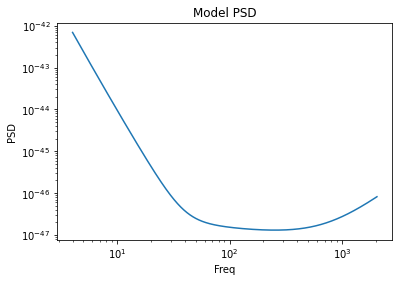

In [21]:
import pycbc.psd

flow = 4.0 # set up the lower cut off frequency
delta_f = 1.0 / 16
flen = int(2048.0/ (delta_f)) + 1
psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)
psd.data[:int(flow/delta_f)] = np.inf #set the value outside the frequency range to infinity
psd.data[-1] = np.inf


pylab.loglog(psd.sample_frequencies, psd)


pylab.title("Model PSD")
pylab.ylabel('PSD')
pylab.xlabel('Freq')

## Plot the horizon distance

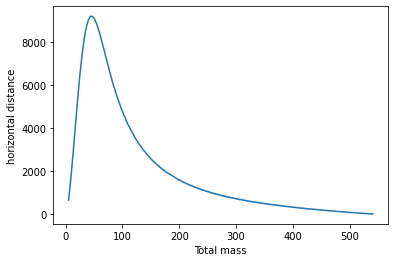

In [22]:
from pycbc.filter import sigmasq

flow = 4.0 #Hz

interval = 1
masses = np.arange(5,550,interval)

a = []
b = []

for m in masses:
  hp, hc = pycbc.waveform.get_fd_waveform(approximant="TaylorF2",
                              mass1=m, mass2=m,
                              f_lower=flow, 
                              delta_f=delta_f,
                              distance = 100)

  SNR = (pycbc.filter.sigmasq(hp, psd))*0.5

# using previous threshold to check for gravitational waves
  if SNR > 8: 
    a.append(SNR/8)
    b.append(m)

pylab.plot(b, a)
pylab.ylabel('horizontal distance')
pylab.xlabel('Total mass')
pylab.show()

## Exercise 3.2
With an increasing mass it is harder to detect the signal, it would need to be closer to be detected.

## Plot PSD for Einstein detector

Text(0.5, 0, 'Freq')

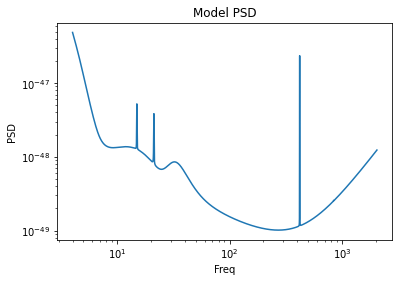

In [23]:
flow = 4.0 # set up the lower cut off frequency
delta_f = 1.0 / 16
flen = int(2048.0/ (delta_f)) + 1
psd = pycbc.psd.EinsteinTelescopeP1600143(flen, delta_f, flow)
psd.data[:int(flow/delta_f)] = np.inf #set the value outside the frequency range to infinity
psd.data[-1] = np.inf


pylab.loglog(psd.sample_frequencies, psd)


pylab.title("Model PSD")
pylab.ylabel('PSD')
pylab.xlabel('Freq')

## Plot the horizon distance

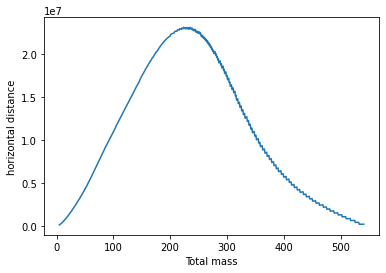

In [24]:
flow = 4.0 #Hz

interval = 1
masses = np.arange(5,550,interval)

a = []
b = []

for m in masses:
  hp, hc = pycbc.waveform.get_fd_waveform(approximant="TaylorF2",
                              mass1=m, mass2=m,
                              f_lower=flow, 
                              delta_f=delta_f,
                              distance = 100)

  SNR = (pycbc.filter.sigmasq(hp, psd))*0.5

  if SNR > 8: 
    a.append(SNR/8)
    b.append(m)

pylab.plot(b, a)
pylab.ylabel('horizontal distance')
pylab.xlabel('Total mass')
pylab.show()